# Extracting and saving data
This tutorial demonstrates how to extract fit data (such as predicted impedance, DRT values, error structure, etc.) and save fits for later analysis.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook

from bayes_drt.inversion import Inverter
import bayes_drt.file_load as fl
import bayes_drt.plotting as bp

%load_ext autoreload
%autoreload 2

In [3]:
# Plot formatting
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

# 1. Load and fit data
For this demo, let's first load some simulated data and fit an `Inverter` instance.

<IPython.core.display.Javascript object>


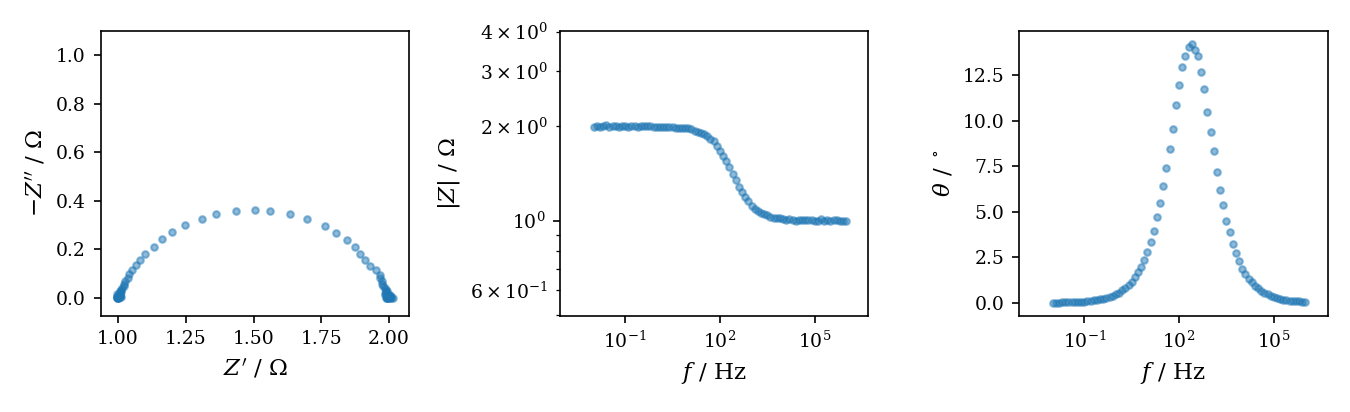

In [9]:
# Load simulated data
circuit = 'ZARC'
err_model = 'Macdonald'
noise_level = 0.25
df_sim = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_{err_model}_{noise_level}.csv'))

# get measured frequencies and impedance
freq_sim, Z_sim = fl.get_fZ(df_sim)

# Plot data
axes = bp.plot_eis(df_sim)

<IPython.core.display.Javascript object>


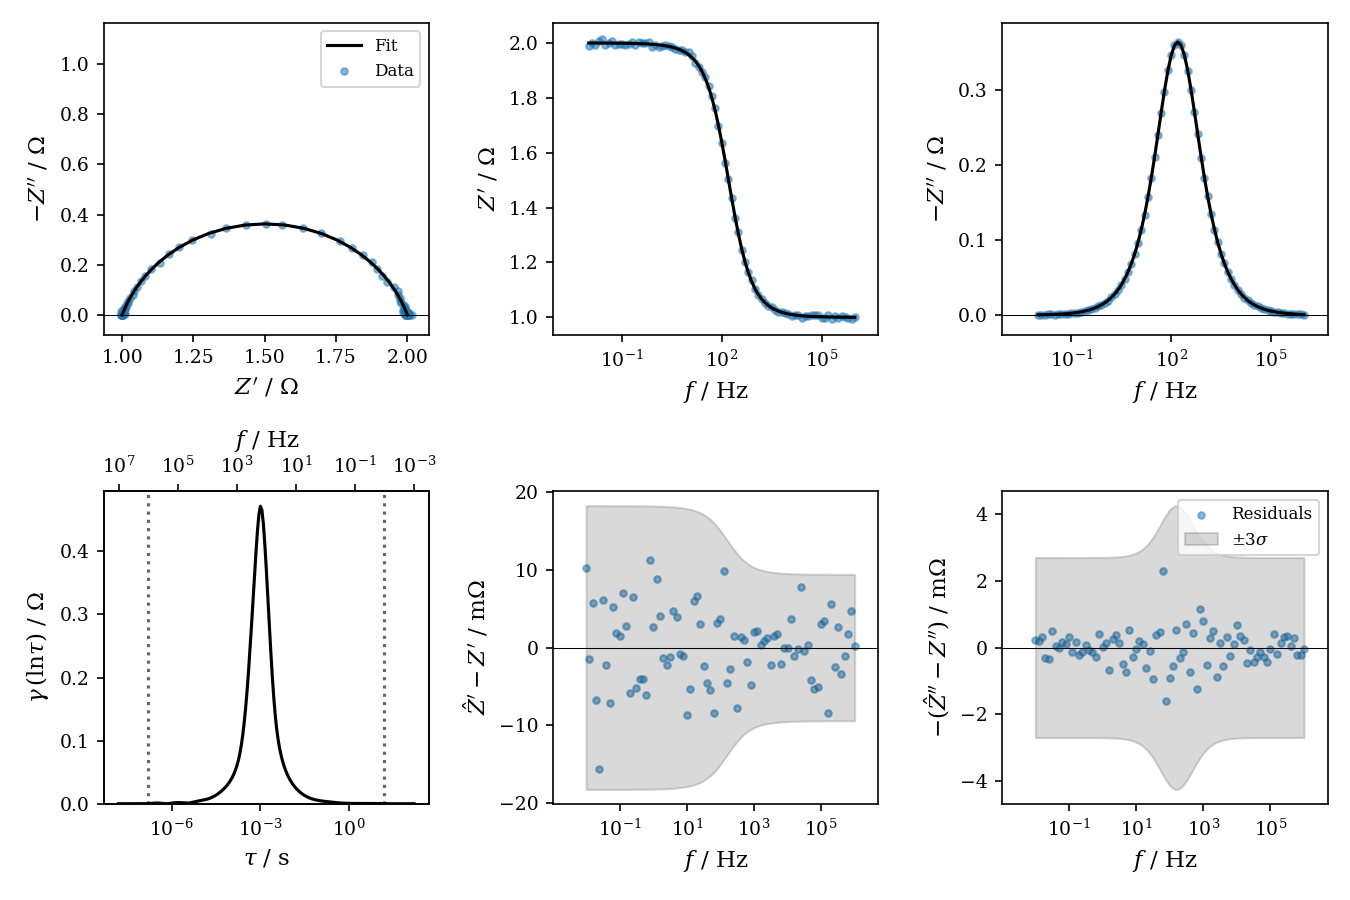

In [11]:
# Create Inverter instance
inv = Inverter(basis_freq=freq_sim)

# Perform MAP fit
inv.fit(freq_sim, Z_sim, nonneg=True)

# Plot results
axes = inv.plot_full_results()

# 2. Extract DRT, impedance, and error structure

The built-in plotting methods such as `plot_full_results` produce most of the plots that we're typically interested in analyzing. However, you may want to access values directly rather than just visualizing them. In this case, you can use several built-in methods to extract the values of interest:
* `predict_Z`: predict impedance for a given array of frequencies
* `predict_distribution`: predict fitted distribution (DRT or DDT) for a given array of time constants
* `predict_sigma`: predict real and imaginary error scales for a given array of frequencies
* `predict_Rp`: predict polarization resistance
* `score`: evaluate the goodness of the impedance fit (chi-square)

Each of these methods is shown below.

In [21]:
# Extract predicted impedance for given frequencies
# Returns complex array
f_pred = np.logspace(7, -3, 101)
Z_pred = inv.predict_Z(f_pred)
print('Predicted impedance:', Z_pred[:10])

Predicted impedance: [0.99917831+4.83863021e-03j 0.99918102+3.78325489e-03j
 0.99918528+2.92964952e-03j 0.99919192+2.23263869e-03j
 0.99920222+1.65563882e-03j 0.99921797+1.16890908e-03j
 0.99924165+7.48279365e-04j 0.99927641+3.74290164e-04j
 0.99932583+3.16240149e-05j 0.9993934 -2.91393405e-04j]


In [22]:
# Extract distribution values for given time constants
# Returns real array
tau_pred = np.logspace(-8, 3, 200)
gamma_pred = inv.predict_distribution(eval_tau=tau_pred)
print('Distribution values:', gamma_pred[:10])

Distribution values: [7.36234365e-67 3.19559606e-61 7.52821803e-56 9.62580408e-51
 6.68015233e-46 2.51617147e-41 5.14397227e-37 5.70770508e-33
 3.43739115e-29 1.12357203e-25]


In [23]:
# Extract error scale for given frequencies
# Returns two real arrays: first is Z_real error scale, second is Z_imag error scale
sigma_re, sigma_im = inv.predict_sigma(f_pred)
print('Real error scale:', sigma_re[:10])
print('Imaginary error scale:', sigma_im[:10])

Real error scale: [0.00314382 0.00314383 0.00314384 0.00314386 0.00314389 0.00314394
 0.003144   0.0031441  0.00314425 0.00314444]
Imaginary error scale: [0.00089881 0.00089876 0.00089873 0.00089871 0.0008987  0.0008987
 0.00089869 0.00089869 0.00089869 0.00089869]


In [24]:
# Extract polarization resistance
# Returns real scalar
Rp = inv.predict_Rp()
print('Polarization resistance:', Rp)

Polarization resistance: 1.0011390057492786


In [25]:
# Calculate goodness of impedance fit with modulus weighting
# Returns real scalar
chi_sq = inv.score(freq_sim, Z_sim, weights='modulus')
print('Chi-square:', chi_sq)

Chi-square: 1.019184535318415e-05


# 3. Save and load fits
After fitting a spectrum, you may want to save the fit so that you can analyze it later without having to re-run the fit. For this purpose, you can use the built-in `save_fit_data` method to save the fit to a file, and then later use the `load_fit_data` method to load the file and regain access to all of the methods built into the `Inverter` class.

You can choose whether to save all of the fit data (including matrices), or only the essential data (i.e. only what is strictly necessary to avoid re-running the fit). If you save only the essential data, some matrices will have to be recalculated to use certain prediction and plotting methods, but the `Inverter` will do this for you automatically when necessary (typically takes less than 1 second). Saving essential data only saves a lot of space, which is helpful if you're running batch fits. Specify `which='all'` (the default) to save all data, or `which='core'` to save only essential data.

In [32]:
# Filenames for fit data storage
full_file = 'all_fit_data.pkl'
core_file = 'core_fit_data.pkl'

# Save all data
inv.save_fit_data(full_file, which='all')
print('Full data size: {:.1f} kb'.format(os.path.getsize(full_file)/1000))

# Save essential data only
inv.save_fit_data(core_file, which='core')
print('Essential data size: {:.1f} kb'.format(os.path.getsize(core_file)/1000))

Dumped pickle to all_fit_data.pkl
Full data size: 542.7 kb
Dumped pickle to core_fit_data.pkl
Essential data size: 5.4 kb


The essential data takes up about 1% as much space as the full dataset.

In [40]:
# Create new instances for loading fit data
inv_full = Inverter()
inv_core = Inverter()

# Load full fit data file
inv_full.load_fit_data(full_file)

# Plot from loaded full data
start = time.time()
Z_pred = inv_full.predict_Z(freq_sim)
print('Prediction time with full data loaded: {:.2f}'.format(time.time() - start))

# Load core fit data file
inv_core.load_fit_data(core_file)

# Plot from loaded core data
start = time.time()
Z_pred = inv_core.predict_Z(freq_sim)
print('Prediction time with core data loaded: {:.2f} s'.format(time.time() - start))

Prediction time with full data loaded: 0.00
Prediction time with core data loaded: 0.14 s


The `Inverter` instance with only core data loaded has to recalculate some matrices in order to calculate the predicted impedance, but this only takes about 0.1 s.

The `Inverter` instances that are loaded from saved fit data can do anything that the original `Inverter` instance can, such as producing plots, as shown below.

<IPython.core.display.Javascript object>


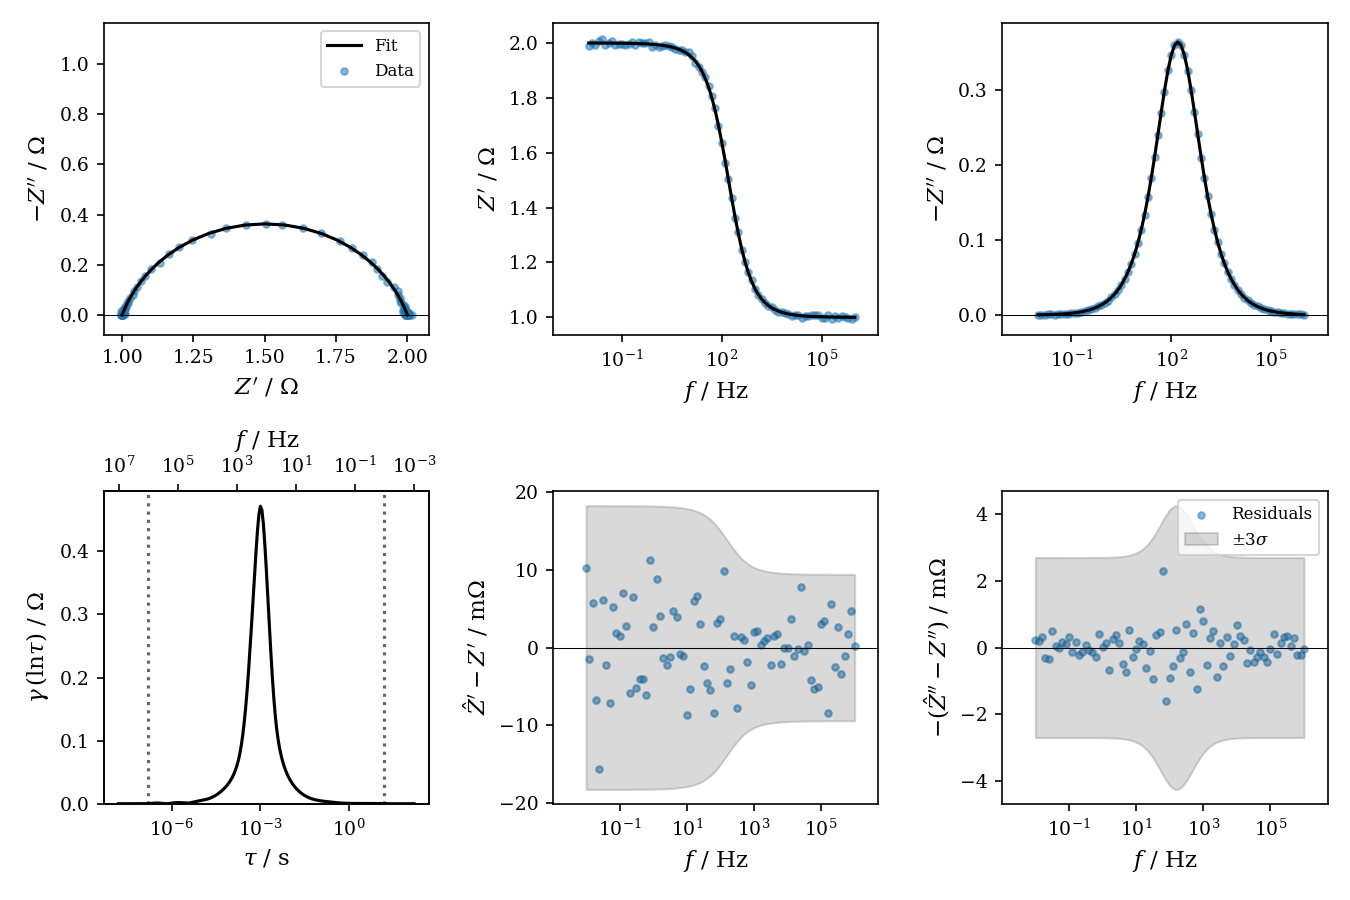

In [41]:
# Plot results with loaded fit data
axes = inv_core.plot_full_results()